# TMDB-IMDb 드라마 데이터 전처리 (최종)

In [30]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats # 통계 분석/검정용
import pingouin as pg # SciPy 통계함수보다 더 많은 정보를 간단한 함수 호출로 반환
import warnings # 경고 메시지 관리용
import scikit_posthocs as sp # 사후 다중 비교 검정용
import re
from scipy.stats import skew, kurtosis
import ast

# 출력 설정
pd.set_option('display.max_columns', None) # 모든 컬럼 다 보기

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick # 축 눈금(tick) 관련 기능 설정
plt.rcParams['axes.unicode_minus'] = False # 그래프에 마이너스(‘−’) 기호가 깨지는 현상을 방지

# 한글 폰트 설정
import platform
if platform.system() == 'Windows': # Windows OS
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # mac OS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'


## 데이터 확인

In [31]:
# 드라마 관련 테이블 (총 9개 -> 최종은 8개)
tv_series = pd.read_parquet('tv_series.parquet')
drama_main_y = pd.read_parquet('00_drama_main.parquet') # 시리즈와 조인해서 'tmdb_rating', 'tmdb_num_votes', 'episode_run_time_average' 가져와야 함
drama_genres = pd.read_parquet('01_drama_genres.parquet')
drama_keyword = pd.read_parquet('02_drama_keyword.parquet')
drama_origin_country = pd.read_parquet('03_drama_origin_country.parquet')
drama_provider = pd.read_parquet('04_drama_providers_flatrate.parquet')
drama_cast = pd.read_parquet('tv_drama_cast.parquet') # 드라마 주연 배우 관련 파싱 테이블
drama_writer = pd.read_parquet('tv_drama_writer.parquet') # 드라마 작가 관련 파싱 테이블
drama_producer = pd.read_parquet('tv_drama_producer.parquet') # 드라마 프로듀서 관련 파싱 테이블

# 데이터 행과 열 개수
print(f"tv_series: {tv_series.shape}")
print(f"drama_main_y: {drama_main_y.shape}")
print(f"drama_genres: {drama_genres.shape}")
print(f"drama_keyword: {drama_keyword.shape}")
print(f"drama_origin_country: {drama_origin_country.shape}")
print(f"drama_provider: {drama_provider.shape}")
print(f"drama_cast: {drama_cast.shape}")
print(f"drama_writer: {drama_writer.shape}")
print(f"drama_producer: {drama_producer.shape}")

tv_series: (138373, 56)
drama_main_y: (3349, 15)
drama_genres: (7081, 3)
drama_keyword: (21609, 2)
drama_origin_country: (3472, 2)
drama_provider: (4703, 2)
drama_cast: (16692, 7)
drama_writer: (3676, 8)
drama_producer: (7871, 8)


In [32]:
drama_main_y.columns

Index(['id', 'series_id', 'imdb_id', 'title', 'original_language', 'overview',
       'first_air_date', 'episode_run_time_average', 'genres', 'keyword',
       'poster_path', 'tmdb_rating', 'tmdb_num_votes', 'imdb_rating',
       'imdb_rating_count'],
      dtype='object')

## 드라마 데이터 전처리 1차 (드라마 메인 테이블 중심)

### imdb_id 보유, vote_count>=30 필터링

In [33]:
pd.set_option('display.max_rows', 1000) 
drama_final = tv_series[
    (tv_series['imdb_id'].notna()) &
    (tv_series['vote_count']>=30)
    ].copy()
drama_final

,id,title,type,adult,backdrop_path,created_by,episode_run_time,first_air_date,genres,genre_ids,homepage,in_production,languages,last_air_date,last_episode_to_air_id,last_episode_to_air_name,last_episode_to_air_overview,last_episode_to_air_vote_average,last_episode_to_air_vote_count,last_episode_to_air_air_date,last_episode_to_air_episode_number,last_episode_to_air_production_code,last_episode_to_air_runtime,last_episode_to_air_season_number,last_episode_to_air_show_id,last_episode_to_air_still_path,next_episode_to_air,networks,number_of_episodes,number_of_seasons,origin_country,original_language,original_name,overview,popularity,poster_path,production_companies,production_countries,seasons,spoken_languages,status,tagline,type_detail,vote_average,vote_count,review,keyword,top_cast,directors,writers,providers_flatrate,providers_rent,providers_buy,imdb_id,imdb_rating,imdb_rating_count
6,36,Medium,tv_series,False,/dVpAGo3TT2IjDyRuKwhNfe9E1A5.jpg,Glenn Gordon Caron,42,2005-01-03,"Crime, Drama, Mystery, Sci-Fi & Fantasy","80, 18, 9648, 10765",http://www.cbs.com/primetime/medium/,False,"en, it",2011-01-21,855.0,Me Without You,When Allison becomes a lawyer and Joe starts a...,8.000,3.0,2011-01-21,13.0,nan,44.0,7.0,36.0,/viRBkXMCIyRJHloP6t4SW3Knspl.jpg,None,"NBC, CBS",128.0,7,US,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,"Pointe Studios, Picturemaker Productions, Gram...",United States of America,S0: Specials (30 eps); S1: Season 1 (16 eps); ...,"English, Italiano",Ended,She Sees What Others Can't.,Scripted,7.462,553,None,"medium, psychic power, paranormal, criminal co...","Patricia Arquette, Jake Weber, Miguel Sandoval...","Aaron Lipstadt, Andy Wolk, Arlene Sanford, Arl...","Analisa Brouet, Arika Lisanne Mittman, Bernade...","{""AR"": [""Paramount Plus"", ""Paramount Plus Appl...",{},"{""AT"": [""Amazon Video""], ""AU"": [""Apple TV""], ""...",tt0412175,7.2,32826.0
12,114,Nathan Barley,tv_series,False,/1BDNaMPm5NA3NaMkcmdqGz45RFm.jpg,"Chris Morris, Charlie Brooker",26,2005-02-11,Comedy,35,http://www.trashbat.co.ck,False,en,2005-03-18,5415.0,The Idiots are Winning,"In the final episode, Nathan finds his way int...",0.000,0.0,2005-03-18,6.0,nan,26.0,1.0,114.0,/c6J7HE6yWV769LDqRKX14rkCAc2.jpg,None,Channel 4,6.0,1,GB,en,Nathan Barley,Nathan Barley is a Channel 4 sitcom written by...,1.3663,/jAd2zeYyWv89L6VRMAtPsssAZ7r.jpg,"Talkback, Channel 4 Television",United Kingdom,S0: Specials (2 eps); S1: Season 1 (6 eps),English,Ended,None,Scripted,7.200,40,None,sitcom,"Nicholas Burns, Julian Barratt, Claire Keelan,...",Chris Morris,"Charlie Brooker, Chris Morris",{},{},{},tt0426654,8.0,4539.0
14,119,Cory in the House,tv_series,False,/nwrnwIbYP3BUFr6WoJApp2vnAAO.jpg,"Marc Warren, Dennis Rinsler",23,2007-01-12,"Comedy, Kids","35, 10762",None,False,en,2008-09-12,5649.0,Mad Songs Pay So Much,"After breaking up with Craig, Meena writes an ...",8.000,2.0,2008-09-12,13.0,213,23.0,2.0,119.0,/g8DVMW8wKXhi8EjM7gaDBWyeZMF.jpg,None,Disney Channel,34.0,2,US,en,Cory in the House,It's a brand new life for Cory Baxter when his...,3.9700,/kf7aiSIFDP1tkxsqckgWxIyuumw.jpg,"It's a Laugh Productions, Warren & Rinsler Pro...",United States of America,S1: Season 1 (21 eps); S2: Season 2 (13 eps),English,Ended,None,Scripted,6.800,92,None,"washington dc, usa, the white house, president...","John D'Aquino, Kyle Massey, Rondell Sheridan, ...","David Kendall, Eric Dean Seaton, Mark Cendrows...","Dennis Rinsler, Edward C. Evans, Marc Warren, ...",{},{},"{""AT"": [""Amazon Video""], ""AU"": [""Apple TV""], ""...",tt0805815,5.0,7507.0
15,132,Fantastic Four: World's Greatest Heroes,tv_series,False,/q0bLjLCBZGhnMcRprx2gWRGdlrp.jpg,"Craig Kyle, Christopher L. Yost",22,2006-09-02,"Animation, Action & Adventure, Sci-Fi & Fantas...","16, 10759, 10765, 10762",None,False,en,2007-10-20,7325.0,Scavenger Hunt,"Terminus, an alien scavenger, comes to steal a...",5.000,1.0,2007-10-20,26.0,nan,22.0,1.0,132.0,/6k1U2f4Lh50BB8htRVye7r5QH5t

### TV 시리즈 중 비드라마 작품의 장르/타이틀 필터링

In [34]:
pd.set_option('display.max_rows', 1000) 
non_drama_genre_pattern = (
    'Reality|Documentary|Talk|News|Kids|Animation|Game Show'
)

non_drama_title_keywords = [
    'wwe', 'wrestling', 'talent', 'survivor',
    'idol', 'competition', 'variety', 'battle'
]

drama_final = drama_final[
    # 1) 장르에 Drama 반드시 포함
    drama_final['genres'].str.contains('Drama', case=False, na=False)
    
    # 2) 예능/다큐/키즈/애니 제거
    &
    ~drama_final['genres'].str.contains(
        non_drama_genre_pattern, case=False, na=False
    )

    # 3) 제목 기반 오디션/레슬링/쇼 제거
    &
    ~drama_final['title'].str.contains(
        '|'.join(non_drama_title_keywords),
        case=False, na=False
    )
].copy()

drama_final[['title','genres']]

,title,genres
6,Medium,"Crime, Drama, Mystery, Sci-Fi & Fantasy"
23,Weeds,"Comedy, Crime, Drama"
27,The Game,"Drama, Comedy"
30,Kyle XY,"Sci-Fi & Fantasy, Drama"
43,Dirt,Drama
...,...,...
129263,Sara - Woman in the Shadows,"Mystery, Drama, Crime"
129957,Revenged Love,"Drama, Action & Adventure"
133087,The Guest,Drama
134012,Los hilos del pasado,"Soap, Drama"


## 시리즈 + 메인 테이블 결합

In [35]:
# 1) drama_main_y에서 필요한 컬럼만 선택
drama_main_y_small = drama_main_y[['id','tmdb_rating', 'tmdb_num_votes', 'episode_run_time_average']]

# 2) drama 중심 merge (left)
drama_final = tv_series.copy()

drama_final = drama_final.merge(
    drama_main_y_small,
    on='id',
    how='left'
)

In [36]:
# id = 시리즈 id (두 컬럼 정보는 동일하므로 메인에는 id만 남겨둠)
(drama_main_y['id'] == drama_main_y['series_id']).all()

np.True_

### 드라마 메인 테이블 결측치 처리

In [37]:
# 원본 카피
drama_final = drama_final.copy()

# 중요도 높은 결측치는 해당 행 제거
critical_cols = ['episode_run_time_average', 'tmdb_num_votes', 'tmdb_rating', 'imdb_rating_count', 'imdb_rating', 'overview']
drama_final = drama_final.dropna(subset=critical_cols)

# 중요도 낮거나 타 테이블로 대체할 컬럼 삭제
drop_cols = ['next_episode_to_air', 'review', 'providers_rent', 'tagline', 'created_by', 'providers_buy', 'writers', 
             'last_episode_to_air_overview', 'homepage', 'last_episode_to_air_still_path', 'directors', 
             'last_episode_to_air_runtime', 'production_countries', 'spoken_languages', 'networks', 'providers_flatrate',
             'languages', 'backdrop_path', 'top_cast', 'keyword', 'seasons', 'production_companies', 'type', 'adult',
             'episode_run_time', 'genres', 'genre_ids', 'last_episode_to_air_id', 'last_episode_to_air_name', 'vote_average',
             'last_episode_to_air_air_date', 'last_episode_to_air_episode_number', 'last_episode_to_air_production_code',
             'last_episode_to_air_season_number', 'last_episode_to_air_show_id', 'origin_country', 'vote_count'
             ]
drama_final = drama_final.drop(columns=drop_cols, errors='ignore') # errors='ignore': 있는 컬럼만 드롭하고, 없는 컬럼은 무시하고 넘어감

# 중요도 낮은 텍스트/카테고리형 "none" 처리
non_cols = ['poster_path', 'original_name']
drama_final[non_cols] = drama_final[non_cols].fillna("none")

# 최종 결측률 확인
drama_final.isna().mean().sort_values(ascending=False)

id                                  0.0
title                               0.0
tmdb_num_votes                      0.0
tmdb_rating                         0.0
imdb_rating_count                   0.0
imdb_rating                         0.0
imdb_id                             0.0
type_detail                         0.0
status                              0.0
poster_path                         0.0
popularity                          0.0
overview                            0.0
original_name                       0.0
original_language                   0.0
number_of_seasons                   0.0
number_of_episodes                  0.0
last_episode_to_air_vote_count      0.0
last_episode_to_air_vote_average    0.0
last_air_date                       0.0
in_production                       0.0
first_air_date                      0.0
episode_run_time_average            0.0
dtype: float64

In [38]:
# 결측치 제거 후 데이터 수
drama_final.shape

(3349, 22)

### 드라마 메인 테이블 데이터 타입 변환

#### 날짜형 변환 및 파생변수 생성

In [39]:
# 날짜 형식 변환
drama_final[['last_air_date', 'first_air_date']] = (
    drama_final[['last_air_date', 'first_air_date']]
    .apply(pd.to_datetime)
    )

In [40]:
# 날짜형 파생변수 생성
drama_final["first_year"] = drama_final["first_air_date"].dt.year
drama_final["last_year"] = drama_final["last_air_date"].dt.year
drama_final["run_years"] = drama_final["last_year"] - drama_final["first_year"] + 1

#### number_of_episodes 타입 변환 (float64 -> int)

In [41]:
# number_of_episodes 타입 변환 (float -> int)
drama_final['number_of_episodes'] = drama_final['number_of_episodes'].astype(int)
drama_final['number_of_episodes']

6         128
23        102
27        147
30         43
43         20
         ... 
128973     18
129263      6
129957     24
133087     20
134012     43
Name: number_of_episodes, Length: 3349, dtype: int64

#### in_production 타입 변환 (bool -> int)

In [42]:
# in_production 처리 (bool -> int)
drama_final['in_production'] = drama_final['in_production'].astype(int)
drama_final['in_production']

6         0
23        0
27        0
30        0
43        0
         ..
128973    0
129263    1
129957    0
133087    1
134012    1
Name: in_production, Length: 3349, dtype: int64

#### category 변환

In [43]:
drama_producer['gender'].value_counts()

gender
2    4771
1    1932
0    1162
3       6
Name: count, dtype: int64

In [44]:
# 드라마 메인 테이블의 object -> category 변환
drama_final[["type_detail", "status", "original_language"]] = drama_final[["type_detail", "status", "original_language"]].astype("category")

# 드라마 크레딧 테이블의 성별을 맵핑 후 int -> category 변환
gender_map = {0:"unknown", 1:"female", 2:"male", 3:"non_binary"}

drama_cast['gender_label'] = drama_cast['gender'].map(gender_map).astype("category")
drama_writer['gender_label'] = drama_writer['gender'].map(gender_map).astype("category")
drama_producer['gender_label'] = drama_producer['gender'].map(gender_map).astype("category")


## 드라마 데이터 전처리 2차 (드라마 전체 테이블)

### 드라마 전체 테이블 결측치 처리

In [45]:
drama = drama_final.copy()

# 결측률 확인
print(f"drama: {drama.isna().mean().sort_values()}")
print(f"drama_genres: {drama_genres.isna().mean().sort_values()}")
print(f"drama_keyword: {drama_keyword.isna().mean().sort_values()}")
print(f"drama_origin_country: {drama_origin_country.isna().mean().sort_values()}")
print(f"drama_provider: {drama_provider.isna().mean().sort_values()}")
print(f"drama_cast: {drama_cast.isna().mean().sort_values()}")
print(f"drama_writer: {drama_writer.isna().mean().sort_values()}")
print(f"drama_producer: {drama_producer.isna().mean().sort_values()}")

drama: id                                  0.0
first_year                          0.0
episode_run_time_average            0.0
tmdb_num_votes                      0.0
tmdb_rating                         0.0
imdb_rating_count                   0.0
imdb_rating                         0.0
imdb_id                             0.0
type_detail                         0.0
status                              0.0
poster_path                         0.0
last_year                           0.0
popularity                          0.0
original_name                       0.0
original_language                   0.0
number_of_seasons                   0.0
number_of_episodes                  0.0
last_episode_to_air_vote_count      0.0
last_episode_to_air_vote_average    0.0
last_air_date                       0.0
in_production                       0.0
first_air_date                      0.0
title                               0.0
overview                            0.0
run_years                        

In [46]:
# drama_genres 결측치만 삭제 (0.0847%)
drama_genres = drama_genres.dropna(subset=['genre'])
drama_genres.isna().sum()

imdb_id     0
genre_id    0
genre       0
dtype: int64

### 드라마 전체 테이블 중복 처리

In [47]:
# 중복 확인
print(f"drama: {drama.duplicated().sum()}")
print(f"drama_genres: {drama_genres.duplicated().sum()}")
print(f"drama_keyword: {drama_keyword.duplicated().sum()}")
print(f"drama_origin_country: {drama_origin_country.duplicated().sum()}")
print(f"drama_provider: {drama_provider.duplicated().sum()}")
print(f"drama_cast: {drama_cast.duplicated().sum()}")
print(f"drama_writer: {drama_writer.duplicated().sum()}")
print(f"drama_producer: {drama_producer.duplicated().sum()}")

drama: 0
drama_genres: 0
drama_keyword: 56
drama_origin_country: 0
drama_provider: 0
drama_cast: 0
drama_writer: 0
drama_producer: 0


In [48]:
# keyword 테이블 중복행 삭제
drama_keyword = drama_keyword.drop_duplicates(subset=["imdb_id", "keyword"])
drama_keyword.duplicated().sum()

np.int64(0)

### 드라마 전체 테이블 이상치 처리

In [49]:
# 기술 통계 확인 (범주형 포함, 가로형으로)
display(drama.describe(include='all').T)
display(drama_genres.describe(include='all').T)
display(drama_keyword.describe(include='all').T)
display(drama_origin_country.describe(include='all').T)
display(drama_provider.describe(include='all').T)
display(drama_cast.describe(include='all').T)
display(drama_writer.describe(include='all').T)
display(drama_producer.describe(include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,3349.0,NaN,NaN,NaN,107775.649746,36.0,62823.0,89572.0,135250.0,300258.0,67961.994284
title,3349,3293,Life on Mars,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_air_date,3349,NaN,NaN,NaN,2018-07-23 09:22:24.759629824,2005-01-03 00:00:00,2015-03-31 00:00:00,2019-10-18 00:00:00,2022-06-27 00:00:00,2025-11-14 00:00:00,NaN
in_production,3349.0,NaN,NaN,NaN,0.138847,0.0,0.0,0.0,0.0,1.0,0.345839
last_air_date,3349,NaN,NaN,NaN,2020-02-07 06:58:47.978500864,2005-03-10 00:00:00,2017-07-28 00:00:00,2021-05-07 00:00:00,2023-09-22 00:00:00,2025-11-30 00:00:00,NaN
last_episode_to_air_vote_average,3349.0,NaN,NaN,NaN,5.086536,0.0,0.0,6.6,8.0,10.0,3.626089
last_episode_to_air_vote_count,3349.0,NaN,NaN,NaN,5.048074,0.0,0.0,2.0,5.0,382.0,13.335386
number_of_episodes,3349.0,NaN,NaN,NaN,37.852792,2.0,8.0,16.0,32.0,4544.0,138.814999
number_of_seasons,3349.0,NaN,NaN,NaN,2.042102,1.0,1.0,1.0,2.0,22.0,1.942503
original_language,3349,34,en,1805,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
imdb_id,7075,3349,tt29764088,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre_id,7075.0,NaN,NaN,NaN,3014.372297,4695.939884,18.0,18.0,35.0,9648.0,10768.0
genre,7075,10,Drama,3349,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq
imdb_id,21553,3349,tt5994364,91
keyword,21553,5279,based on novel or book,498


,count,unique,top,freq
imdb_id,3472,3349,tt7950706,5
origin_country,3472,11,us,1298


,count,unique,top,freq
imdb_id,4703,3349,tt0460681,9
providers_flatrate,4703,12,none,2540


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cast_id,16692.0,NaN,NaN,NaN,997789.849688,1012362.589796,3.0,73610.0,1014784.0,1573831.0,5741974.0
name,16692,11077,Ji Chang-wook,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,16692.0,NaN,NaN,NaN,1.514917,0.555002,0.0,1.0,2.0,2.0,3.0
popularity,16692.0,NaN,NaN,NaN,1.656661,1.727832,0.0,0.6781,1.2498,2.06685,41.0083
character,16692,15760,Anna,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
series_id,16692.0,NaN,NaN,NaN,105502.12515,66957.49914,36.0,63238.5,86588.0,131992.0,302463.0
profile_path,16185,10722,/afgwHQJ3BP6ygM2ZUUZO60U84q0.jpg,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender_label,16692,4,male,8883,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
crew_member_id,3676.0,NaN,NaN,NaN,1973250.384657,1405744.917934,1.0,1142635.75,1790375.0,2898301.25,5861096.0
name,3676,2920,Harlan Coben,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,3676.0,NaN,NaN,NaN,1.113439,0.852957,0.0,0.0,1.0,2.0,3.0
popularity,3676.0,NaN,NaN,NaN,0.353118,0.486152,0.0,0.074775,0.1989,0.4475,8.729
department,3676,2,Writing,3554,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job,3676,39,Writer,1418,NaN,NaN,NaN,NaN,NaN,NaN,NaN
series_id,3676.0,NaN,NaN,NaN,113802.850653,66402.72229,36.0,67420.25,94372.0,155426.0,297464.0
profile_path,1481,1057,/afyCuOyjYCt18FQloW2zMK2aS6B.jpg,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender_label,3676,4,male,1551,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
crew_member_id,7871.0,NaN,NaN,NaN,1134311.313048,1136478.446306,18.0,65918.0,1213443.0,1676026.0,5860879.0
name,7871,4797,Lucy Richer,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7871.0,NaN,NaN,NaN,1.460043,0.738416,0.0,1.0,2.0,2.0,3.0
popularity,7871.0,NaN,NaN,NaN,0.713034,1.500843,0.0,0.1583,0.2964,0.69415,41.0083
department,7871,1,Production,7871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job,7871,1,Executive Producer,7871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
series_id,7871.0,NaN,NaN,NaN,115384.428916,66025.61865,186.0,70514.0,94796.0,154385.0,284792.0
profile_path,4407,2421,/ppXZzObx9sg5ReZkTkMM2CfdN5Z.jpg,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender_label,7871,4,male,4771,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 수치형 분포 확인 - 드라마 메인 테이블

In [50]:
# 함수화
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def drama_numeric(df, cols):
    """
    수치형 변수 단변량 분석:
    - 히스토그램 + KDE
    - 박스플롯
    - Q-Q plot (정규성 시각화)
    - 왜도 / 첨도 계산
    - IQR 기반 이상치 개수 출력
    """

    results = {}

    for col in cols:
        print(f"\n====================== {col} ======================")

        series = df[col].dropna()

        # 기본 통계
        describe = series.describe()
        skew = series.skew()
        kurt = series.kurt()

        # IQR 기반 이상치 계산
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = ((series < lower) | (series > upper)).sum()

        print(describe)
        print(f"왜도 (Skewness): {skew:.3f}")
        print(f"첨도 (Kurtosis): {kurt:.3f}")
        print(f"IQR: {IQR:.3f}, 이상치 개수: {outliers}")

        # --------------------------------------------
        # 그래프: 히스토그램 + 박스플롯 + Q-Q 플롯
        # --------------------------------------------
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))

        # 1) Histogram + KDE
        sns.histplot(series, bins=40, kde=True, ax=axes[0])
        axes[0].set_title(f"Histogram + KDE: {col}")

        # 2) Boxplot
        sns.boxplot(x=series, ax=axes[1])
        axes[1].set_title(f"Boxplot: {col}")

        # 3) Q-Q Plot
        stats.probplot(series, dist="norm", plot=axes[2])
        # 점 색상 정리
        try:
            axes[2].get_lines()[0].set_markerfacecolor('steelblue')
            axes[2].get_lines()[0].set_markeredgecolor('steelblue')
        except:
            pass
        axes[2].set_title(f"Q-Q Plot: {col}")
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        results[col] = {
            "describe": describe,
            "skew": skew,
            "kurt": kurt,
            "outliers": outliers
        }

    return results



====================== imdb_rating ======================
count    3349.000000
mean        7.273305
std         0.825753
min         2.100000
25%         6.800000
50%         7.400000
75%         7.800000
max         9.500000
Name: imdb_rating, dtype: float64
왜도 (Skewness): -0.963
첨도 (Kurtosis): 2.581
IQR: 1.000, 이상치 개수: 63


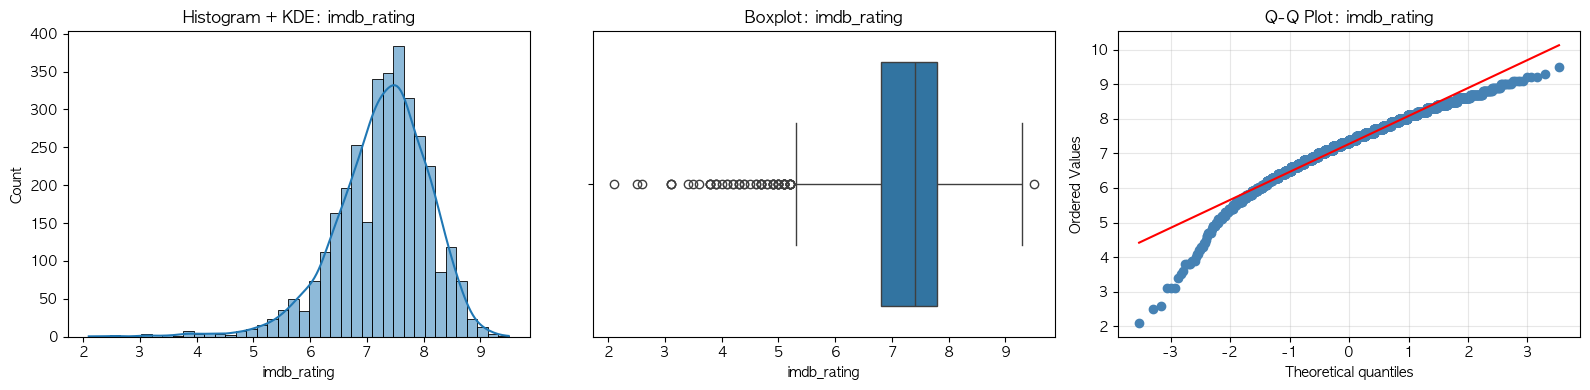


====================== imdb_rating_count ======================
count    3.349000e+03
mean     2.824507e+04
std      9.630423e+04
min      9.000000e+00
25%      2.326000e+03
50%      6.176000e+03
75%      1.844600e+04
max      2.507703e+06
Name: imdb_rating_count, dtype: float64
왜도 (Skewness): 13.177
첨도 (Kurtosis): 271.874
IQR: 16120.000, 이상치 개수: 430


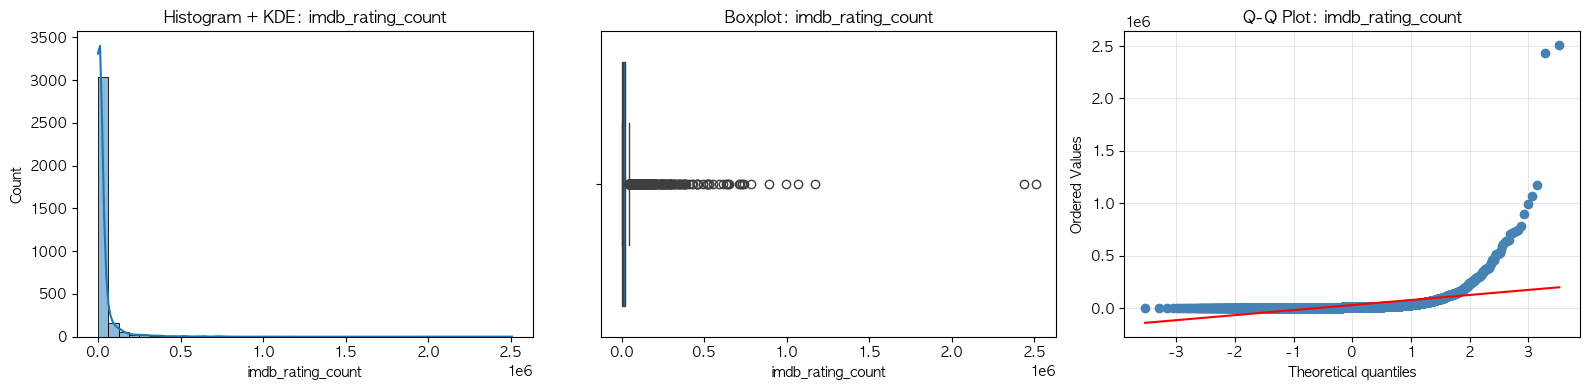


====================== number_of_episodes ======================
count    3349.000000
mean       37.852792
std       138.814999
min         2.000000
25%         8.000000
50%        16.000000
75%        32.000000
max      4544.000000
Name: number_of_episodes, dtype: float64
왜도 (Skewness): 22.270
첨도 (Kurtosis): 627.057
IQR: 24.000, 이상치 개수: 395


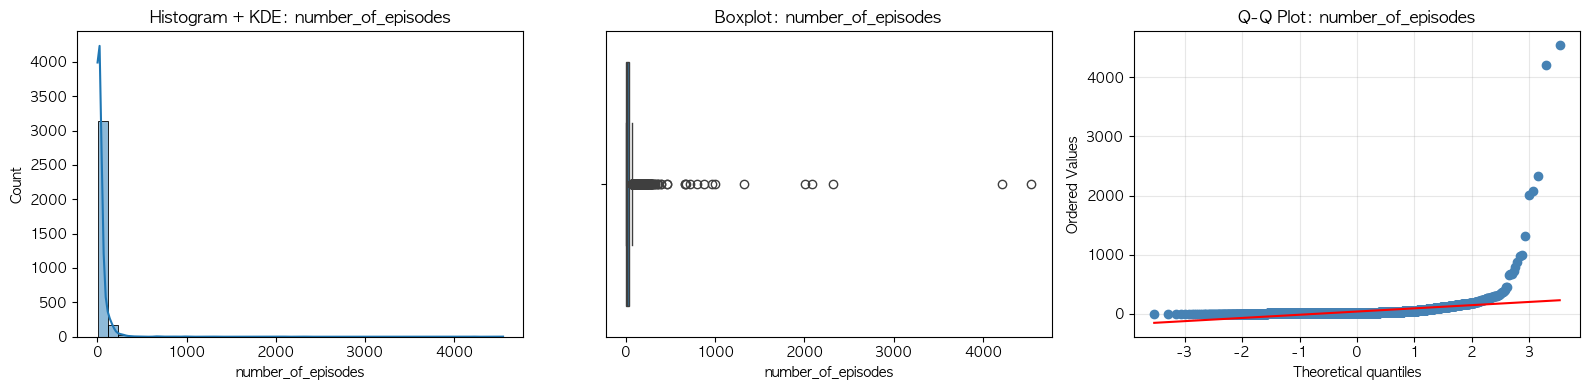


====================== tmdb_num_votes ======================
count     3349.000000
mean       394.735145
std       1229.314577
min         30.000000
25%         49.000000
50%        100.000000
75%        260.000000
max      25846.000000
Name: tmdb_num_votes, dtype: float64
왜도 (Skewness): 9.532
첨도 (Kurtosis): 125.621
IQR: 211.000, 이상치 개수: 438


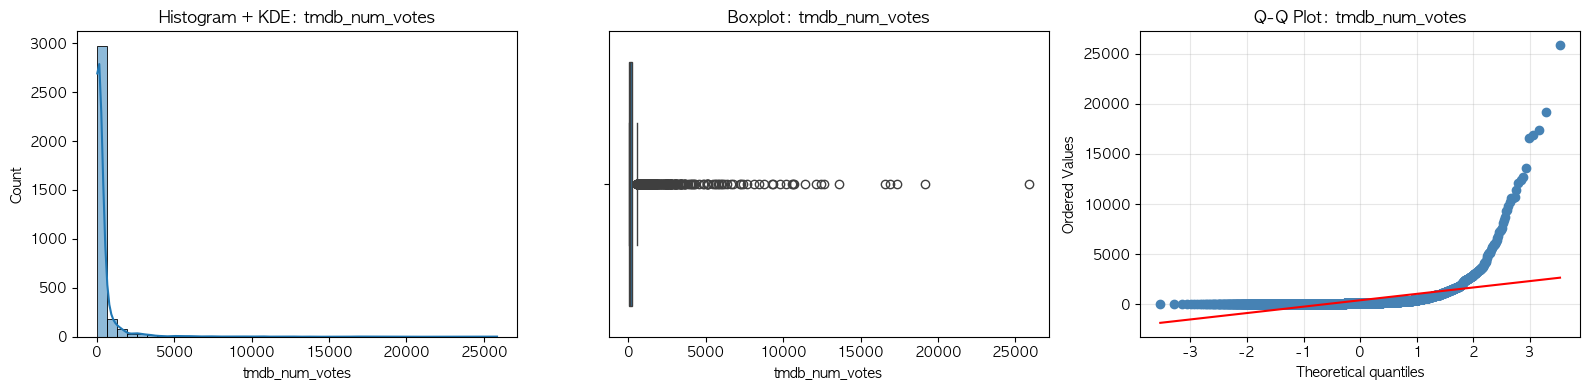


====================== tmdb_rating ======================
count    3349.000000
mean        7.305123
std         0.698050
min         2.300000
25%         6.846000
50%         7.309000
75%         7.800000
max         9.600000
Name: tmdb_rating, dtype: float64
왜도 (Skewness): -0.428
첨도 (Kurtosis): 1.127
IQR: 0.954, 이상치 개수: 25


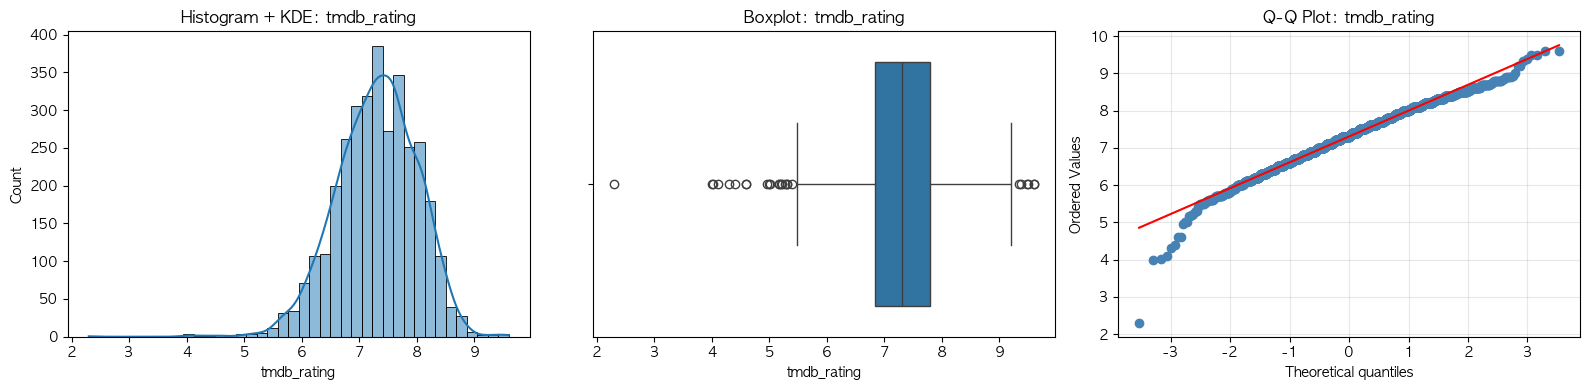


====================== number_of_seasons ======================
count    3349.000000
mean        2.042102
std         1.942503
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        22.000000
Name: number_of_seasons, dtype: float64
왜도 (Skewness): 3.696
첨도 (Kurtosis): 21.471
IQR: 1.000, 이상치 개수: 468


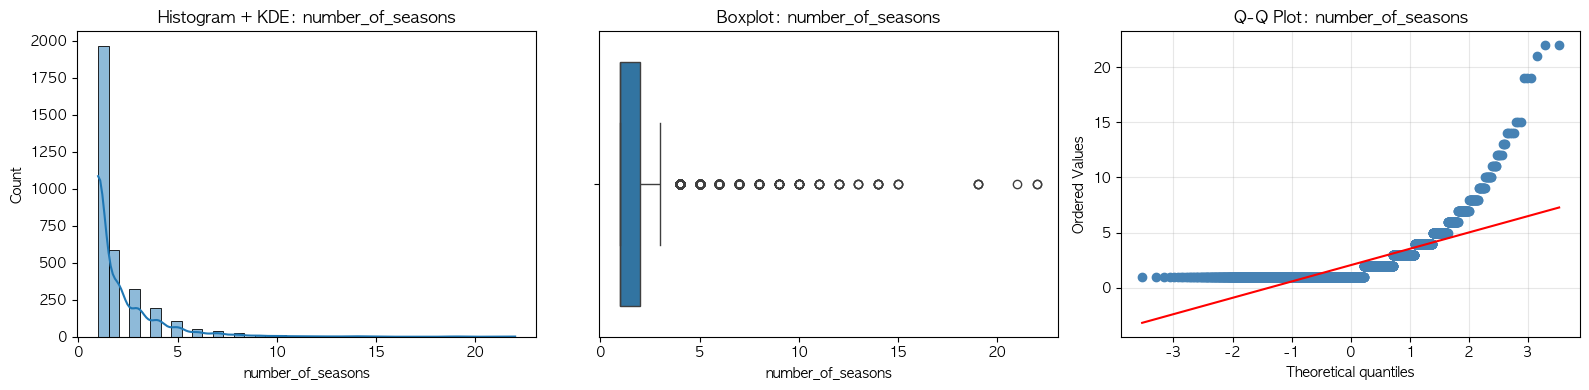


====================== last_episode_to_air_vote_average ======================
count    3349.000000
mean        5.086536
std         3.626089
min         0.000000
25%         0.000000
50%         6.600000
75%         8.000000
max        10.000000
Name: last_episode_to_air_vote_average, dtype: float64
왜도 (Skewness): -0.446
첨도 (Kurtosis): -1.426
IQR: 8.000, 이상치 개수: 0


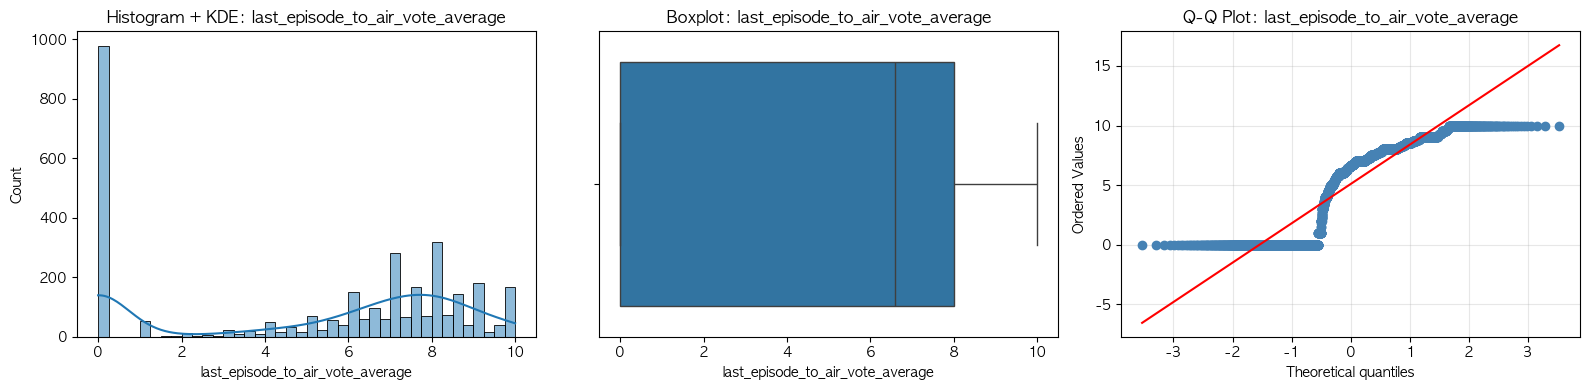


====================== popularity ======================
count    3349.000000
mean        5.879669
std        10.933898
min         0.021400
25%         1.867800
50%         3.090800
75%         5.676300
max       281.966500
Name: popularity, dtype: float64
왜도 (Skewness): 9.464
첨도 (Kurtosis): 157.672
IQR: 3.809, 이상치 개수: 333


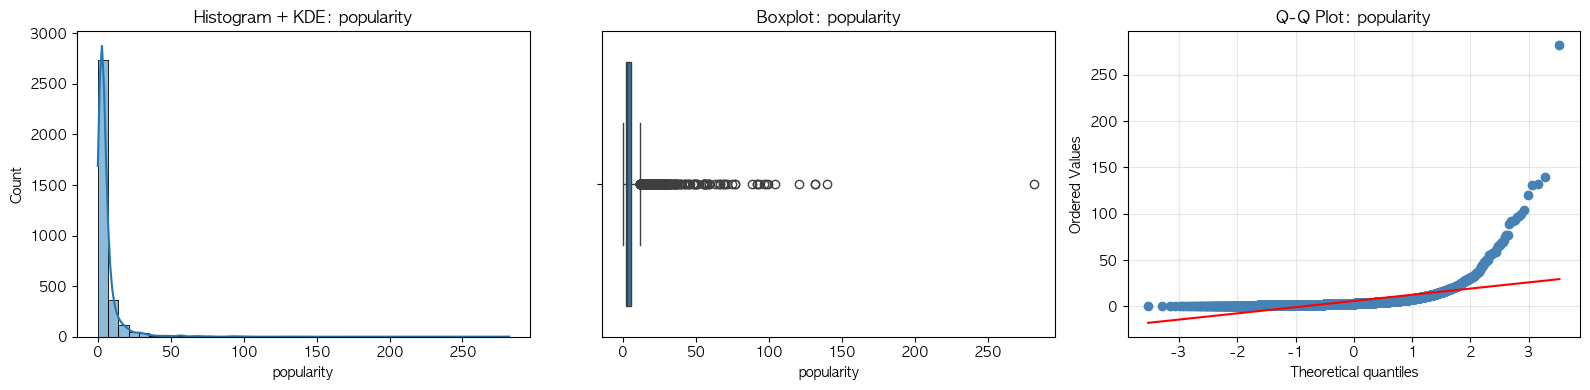


====================== first_year ======================
count    3349.000000
mean     2018.068976
std         5.066083
min      2005.000000
25%      2015.000000
50%      2019.000000
75%      2022.000000
max      2025.000000
Name: first_year, dtype: float64
왜도 (Skewness): -0.799
첨도 (Kurtosis): -0.191
IQR: 7.000, 이상치 개수: 0


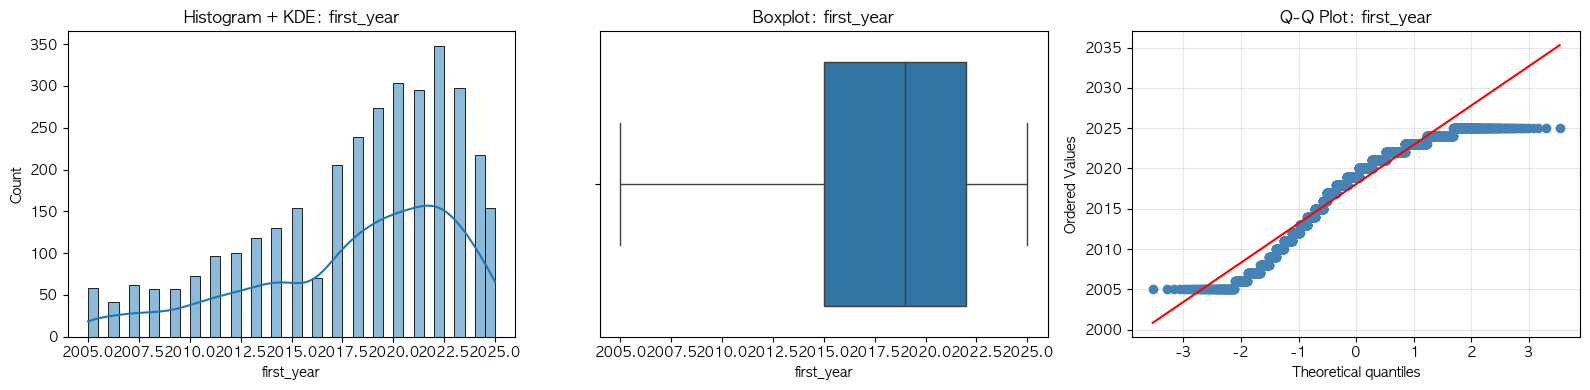


====================== last_year ======================
count    3349.000000
mean     2019.584354
std         4.693007
min      2005.000000
25%      2017.000000
50%      2021.000000
75%      2023.000000
max      2025.000000
Name: last_year, dtype: float64
왜도 (Skewness): -1.019
첨도 (Kurtosis): 0.419
IQR: 6.000, 이상치 개수: 76


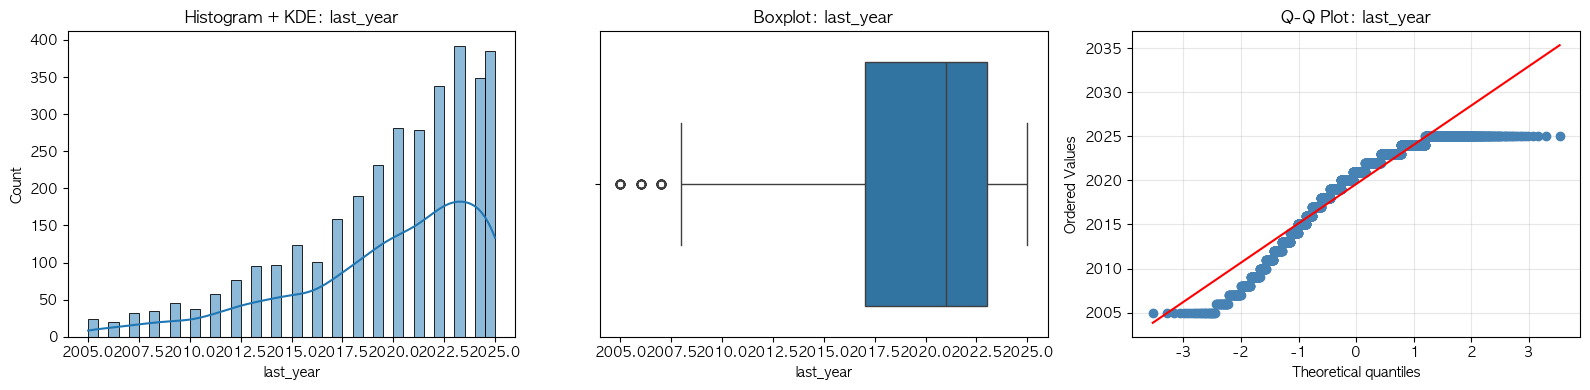


====================== run_years ======================
count    3349.000000
mean        2.515378
std         2.472939
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        21.000000
Name: run_years, dtype: float64
왜도 (Skewness): 2.704
첨도 (Kurtosis): 10.325
IQR: 2.000, 이상치 개수: 223


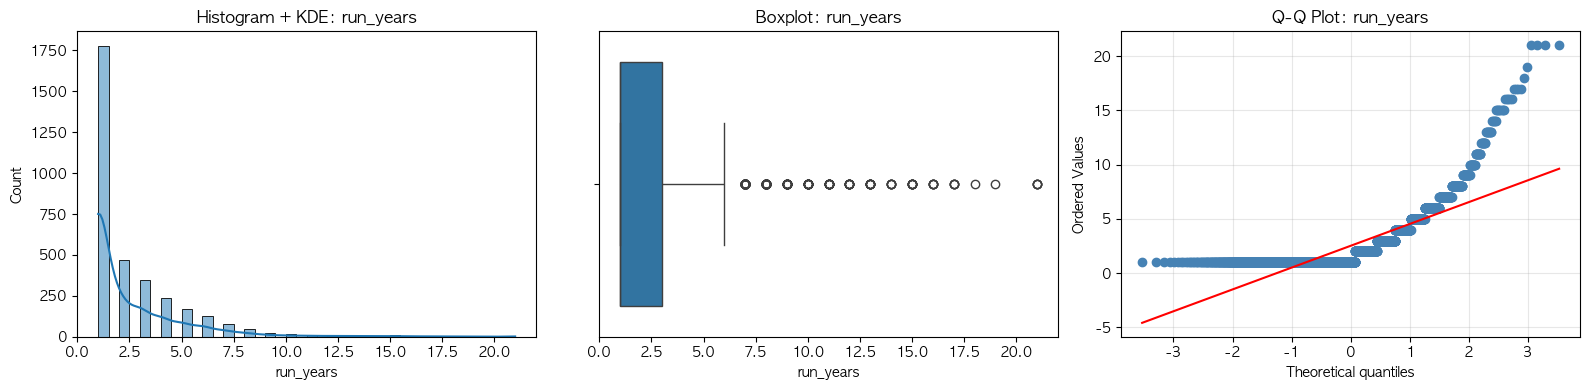


====================== episode_run_time_average ======================
count    3349.000000
mean       50.579875
std        28.755659
min         0.000000
25%        43.000000
50%        48.000000
75%        58.000000
max       736.000000
Name: episode_run_time_average, dtype: float64
왜도 (Skewness): 11.383
첨도 (Kurtosis): 206.213
IQR: 15.000, 이상치 개수: 220


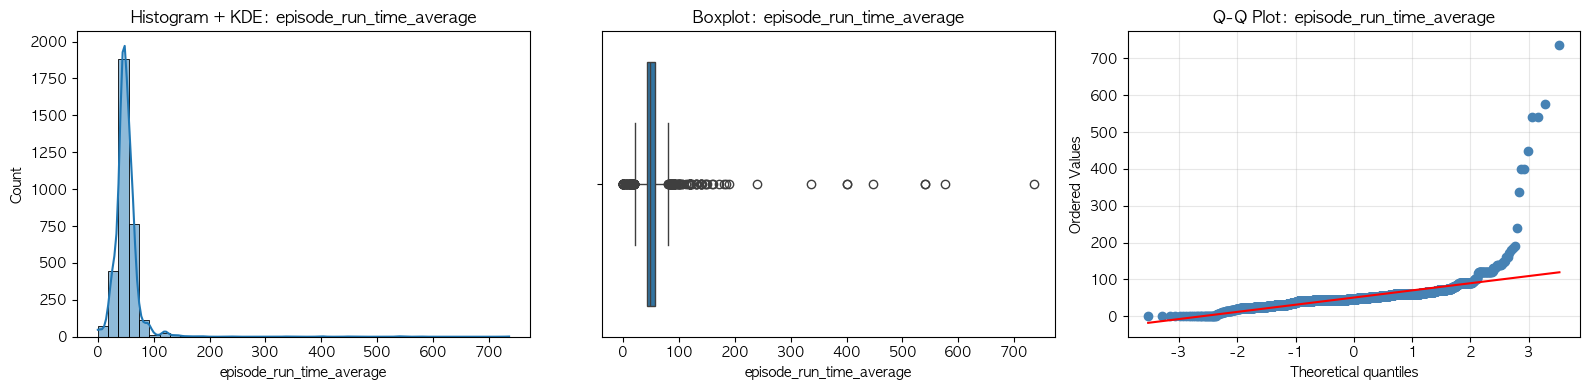

{'imdb_rating': {'describe': count    3349.000000
  mean        7.273305
  std         0.825753
  min         2.100000
  25%         6.800000
  50%         7.400000
  75%         7.800000
  max         9.500000
  Name: imdb_rating, dtype: float64,
  'skew': np.float64(-0.9629496141737829),
  'kurt': np.float64(2.5805519711348066),
  'outliers': np.int64(63)},
 'imdb_rating_count': {'describe': count    3.349000e+03
  mean     2.824507e+04
  std      9.630423e+04
  min      9.000000e+00
  25%      2.326000e+03
  50%      6.176000e+03
  75%      1.844600e+04
  max      2.507703e+06
  Name: imdb_rating_count, dtype: float64,
  'skew': np.float64(13.176742346432766),
  'kurt': np.float64(271.87433612256854),
  'outliers': np.int64(430)},
 'number_of_episodes': {'describe': count    3349.000000
  mean       37.852792
  std       138.814999
  min         2.000000
  25%         8.000000
  50%        16.000000
  75%        32.000000
  max      4544.000000
  Name: number_of_episodes, dtype: flo

In [51]:
# 드라마 메인 테이블 수치형 컬럼 적용
drama_int_cols = ['imdb_rating', 'imdb_rating_count', 'number_of_episodes', 'tmdb_num_votes', 'tmdb_rating',
        'number_of_seasons', 'last_episode_to_air_vote_average', 'popularity', 
        'first_year', 'last_year', 'run_years', 'episode_run_time_average'
        ]

drama_numeric(drama, drama_int_cols)

#### 드라마 메인 테이블 전처리 방향

- 로그 변환이 불필요한 변수
  - imdb_rating
  - first_year
  - last_year
  - last_episode_to_air_vote_average
  - tmdb_rating

- 구조적 누락이라 그대로 유지하는 컬럼 
  - last_episode_to_air_vote_average == 0 유지 (방영 전/신작이거나, 에피소드에는 vote_average가 거의 없음) -> 전체 30% 비중이라, 삭제하면 치명적
  - writer_count == 0 유지
  - producer_count == 0 유지

- 로그 변환이 필요한 변수
  - imdb_rating_count
  - number_of_episodes
  - number_of_seasons
  - run_years
  - episode_run_time_average
  - popularity
  - tmdb_num_votes

- 이상치 처리가 필요한 컬럼
  - number_of_episodes (4544회 -> 비정상적으로 큰 값 삭제)
  - episode_run_time_average (736분 -> 비정상 런타임 삭제)
  - episode_run_time_average == 0 삭제
  - popularity (극단값 -> 삭제)
  - popularity == 0 삭제

- 이상치 제거 없이 winsorization(상하위 1~2%) 클리핑 컬럼
  - imdb_rating_count
  - popularity
  - tmdb_num_votes

### 드라마 메인 테이블 이상치 처리

In [52]:
import numpy as np
import pandas as pd

# ============================================
# 1) 구조적 이상치 제거 (명확한 비정상 값)
# ============================================

# 1-1) number_of_episodes == 4544 단일 이상치 제거
drama = drama[drama["number_of_episodes"] != 4544]

# 1-2) episode_run_time_avg == 736 단일 이상치 제거
drama = drama[drama["episode_run_time_average"] != 736]

# 1-3) episode_run_time_avg == 0 제거 (30개 제거)
drama = drama[drama["episode_run_time_average"] > 0]

# 1-4) popularity == 0 제거 (데이터 누락)
drama = drama[drama["popularity"] > 0]

# ============================================
# 2) Winsorization (상위 1%)
#    * 이상치 삭제 없이 클리핑
# ============================================

winsor_cols = ["imdb_rating_count", "popularity", 'tmdb_num_votes']

for col in winsor_cols:
    upper = drama[col].quantile(0.99)     # 상위 1%
    drama[col] = drama[col].clip(upper=upper)


# ============================================
# 3) 로그 변환 (long-tail 변수)
# ============================================

log_vars = [
    "imdb_rating_count",
    "number_of_episodes",
    "number_of_seasons",
    "run_years",
    "episode_run_time_average",
    "popularity",
    'tmdb_num_votes'
]

for col in log_vars:
    drama[f"{col}_log"] = np.log1p(drama[col])  # log(col + 1)


# ============================================
# 4) 최종 출력
# ============================================

print("📌 전처리 완료!")
print("드라마 메인 테이블 최종 데이터 행 수:", len(drama))

📌 전처리 완료!
드라마 메인 테이블 최종 데이터 행 수: 3317


### 드라마 크레딧 테이블 성별 분포

- 0 → 정보 없음 / 기재되지 않음
- 1 → 여성(Female)
- 2 → 남성(Male)
- 3 → 논바이너리/기타(Non-binary / Other)


<Axes: xlabel='gender_label', ylabel='count'>

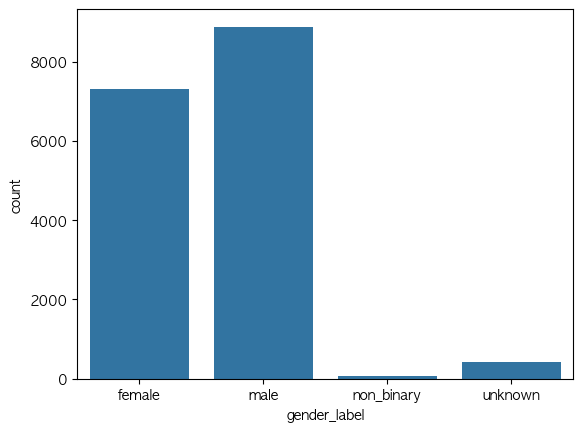

In [53]:
# 성별 구성 - 주연 배우
sns.countplot(x="gender_label", data=drama_cast)

<Axes: xlabel='gender_label', ylabel='count'>

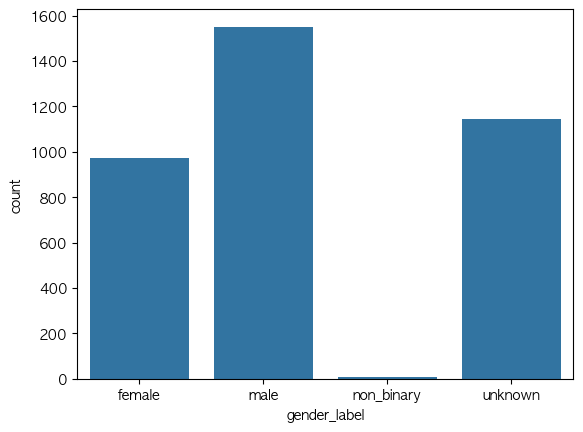

In [54]:
# 성별 구성 - 작가
sns.countplot(x="gender_label", data=drama_writer)

<Axes: xlabel='gender_label', ylabel='count'>

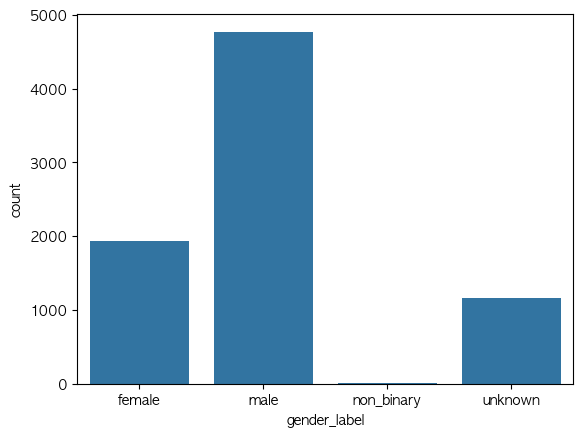

In [55]:
# 성별 구성 - 프로듀서
sns.countplot(x="gender_label", data=drama_producer)

## 전처리 후 데이터 개수 확인

In [56]:
# 데이터 행과 열 개수 (8개 테이블)
print(f"drama: {drama.shape}")
print(f"drama_genres: {drama_genres.shape}")
print(f"drama_keyword: {drama_keyword.shape}")
print(f"drama_origin_country: {drama_origin_country.shape}")
print(f"drama_provider: {drama_provider.shape}")
print(f"drama_cast: {drama_cast.shape}")
print(f"drama_writer: {drama_writer.shape}")
print(f"drama_producer: {drama_producer.shape}")

drama: (3317, 32)
drama_genres: (7075, 3)
drama_keyword: (21553, 2)
drama_origin_country: (3472, 2)
drama_provider: (4703, 2)
drama_cast: (16692, 8)
drama_writer: (3676, 9)
drama_producer: (7871, 9)


## 최종 파일 저장

In [ ]:
# drama.to_parquet('drama_final.parquet', index=False)
# drama_genres.to_parquet('drama_genres_final.parquet', index=False)
# drama_keyword.to_parquet('drama_keyword_final.parquet', index=False)
# drama_origin_country.to_parquet('drama_origin_country_final.parquet', index=False)
# drama_provider.to_parquet('drama_provider_final.parquet', index=False)
# drama_cast.to_parquet('drama_cast_final.parquet', index=False)
# drama_writer.to_parquet('drama_writer_final.parquet', index=False)
# drama_producer.to_parquet('drama_producer_final.parquet', index=False)

## 파일 확인

In [ ]:
# 드라마 테이블 (총 9개)
drama_final = pd.read_parquet('drama_final.parquet')
drama_genres_final = pd.read_parquet('drama_genres_final.parquet')
drama_keyword_final = pd.read_parquet('drama_keyword_final.parquet')
drama_origin_country_final = pd.read_parquet('drama_origin_country_final.parquet')
drama_provider_final = pd.read_parquet('drama_provider_final.parquet')
drama_cast_final = pd.read_parquet('drama_cast_final.parquet')
drama_writer_final = pd.read_parquet('drama_writer_final.parquet')
drama_producer_final = pd.read_parquet('drama_producer_final.parquet')
# tv_review = pd.read_parquet('tv_reviews.parquet') -> 영화/드라마 통합본 별도

In [59]:
drama_final

,id,title,first_air_date,in_production,last_air_date,last_episode_to_air_vote_average,last_episode_to_air_vote_count,number_of_episodes,number_of_seasons,original_language,original_name,overview,popularity,poster_path,status,type_detail,imdb_id,imdb_rating,imdb_rating_count,tmdb_rating,tmdb_num_votes,episode_run_time_average,first_year,last_year,run_years,imdb_rating_count_log,number_of_episodes_log,number_of_seasons_log,run_years_log,episode_run_time_average_log,popularity_log,tmdb_num_votes_log
0,36,Medium,2005-01-03,0,2011-01-21,8.000,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.761200,3.026232,6.317165
1,186,Weeds,2005-08-07,0,2012-09-16,7.800,11.0,102,8,en,Weeds,"After the unexpected death of her husband, a s...",19.8985,/gKUsBTa5b0GY7U4iWBseeBalfjO.jpg,Ended,Scripted,tt0439100,7.9,121234.0,7.484,935.0,27.0,2005,2012,8,11.705486,4.634729,2.197225,2.197225,3.332205,3.039677,6.841615
2,211,The Game,2006-10-01,0,2015-08-05,0.000,0.0,147,9,en,The Game,When her boyfriend Derwin Davis is chosen as t...,6.4524,/zmvRaCRcmi6lsriYxZmAR6uWHPS.jpg,Ended,Scripted,tt0772137,6.9,5070.0,7.500,40.0,30.0,2006,2015,10,8.531293,4.997212,2.302585,2.397895,3.433987,2.008536,3.713572
3,219,Kyle XY,2006-06-26,0,2009-03-16,7.500,2.0,43,3,en,Kyle XY,A suburban family that takes in a mysterious t...,6.3551,/4omwjf3HgGx4nZXcA0Avmd9bQny.jpg,Canceled,Scripted,tt0756509,7.4,31609.0,7.044,365.0,44.0,2006,2009,4,10.361229,3.784190,1.386294,1.609438,3.806662,1.995394,5.902633
4,284,Dirt,2007-01-02,0,2008-04-13,0.000,0.0,20,2,en,Dirt,Dirt is an American television serial broadcas...,2.6111,/JZs8u8XfZJDjv72LUidoXdb9qz.jpg,Canceled,Scripted,tt0496275,6.9,7251.0,6.675,40.0,55.0,2007,2008,2,8.889033,3.044522,1.098612,1.098612,4.025352,1.284012,3.713572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,290276,Unspeakable Sins,2025-07-30,0,2025-07-30,0.000,0.0,18,1,es,Pecados inconfesables,A woman in a controlling marriage finds solace...,8.6071,/30eSqR2XPGz53eGElt6YAvH7cPX.jpg,Ended,Scripted,tt37504309,5.4,1359.0,7.359,46.0,37.0,2025,2025,1,7.215240,2.944439,0.693147,0.693147,3.637586,2.262502,3.850148
3313,291256,Sara - Woman in the Shadows,2025-06-03,1,2025-06-03,4.333,3.0,6,1,it,Sara - La donna nell'ombra,The suspicious death of her son pushes a forme...,3.3019,/9QVSjcrWGjV46DlSLfh9JI4oIaa.jpg,Returning Series,Scripted,tt28243363,6.3,2004.0,6.400,32.0,54.0,2025,2025,1,7.603399,1.945910,0.693147,0.693147,4.007333,1.459057,3.496508
3314,292035,Revenged Love,2025-06-16,0,2025-08-12,0.000,0.0,24,1,zh,逆爱,"After Wu Suo-wei's girlfriend dumps him, he de...",25.0729,/j5KWzpPAi4JC42GGrVWDFL6G2gY.jpg,Ended,Scripted,tt37370861,8.8,4212.0,8.260,52.0,45.0,2025,2025,1,8.345930,3.218876,0.693147,0.693147,3.828641,3.260896,3.970292
3315,297464,The Guest,2025-09-24,1,2025-09-24,0.000,0.0,20,1,es,La huésped,A seemingly perfect household unravels when an...,10.5993,/fBMRxziwviMBVLOCe1i4qtwRXKj.jpg,Returning Series,Scripted,tt37065878,5.4,645.0,7.900,31.0,42.0,2025,2025,1,6.470800,3.044522,0.693147,0.693147,3.761200,2.450945,3.465736


In [60]:
drama_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3317 non-null   int64         
 1   title                             3317 non-null   object        
 2   first_air_date                    3317 non-null   datetime64[ns]
 3   in_production                     3317 non-null   int64         
 4   last_air_date                     3317 non-null   datetime64[ns]
 5   last_episode_to_air_vote_average  3317 non-null   float64       
 6   last_episode_to_air_vote_count    3317 non-null   float64       
 7   number_of_episodes                3317 non-null   int64         
 8   number_of_seasons                 3317 non-null   int64         
 9   original_language                 3317 non-null   category      
 10  original_name                     3317 non-null 

In [29]:
drama_final.columns

Index(['id', 'title', 'first_air_date', 'in_production', 'last_air_date',
       'last_episode_to_air_vote_average', 'last_episode_to_air_vote_count',
       'number_of_episodes', 'number_of_seasons', 'original_language',
       'original_name', 'overview', 'popularity', 'poster_path', 'status',
       'type_detail', 'imdb_id', 'imdb_rating', 'imdb_rating_count',
       'tmdb_rating', 'tmdb_num_votes', 'episode_run_time_average',
       'first_year', 'last_year', 'run_years'],
      dtype='object')

In [58]:
drama_genres_final

,imdb_id,genre_id,genre
0,tt0412175,80,Crime
1,tt0412175,18,Drama
2,tt0412175,9648,Mystery
3,tt0412175,10765,Sci-Fi & Fantasy
4,tt0439100,35,Comedy
...,...,...,...
7070,tt37370861,18,Drama
7071,tt37370861,10759,Action & Adventure
7072,tt37065878,18,Drama
7073,tt36595665,10766,Soap


In [71]:
drama_genres_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7075 entries, 0 to 7074
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   imdb_id   7075 non-null   object
 1   genre_id  7075 non-null   int32 
 2   genre     7075 non-null   object
dtypes: int32(1), object(2)
memory usage: 138.3+ KB


In [59]:
drama_keyword_final

,imdb_id,keyword
0,tt0412175,medium
1,tt0412175,psychic power
2,tt0412175,paranormal
3,tt0412175,criminal consultant
4,tt0412175,phoenix
...,...,...
21548,tt37370861,bisexual
21549,tt37370861,jealous ex
21550,tt37370861,snake fighting
21551,tt37065878,psychological thriller


In [70]:
drama_keyword.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21553 entries, 0 to 21608
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   imdb_id  21553 non-null  object
 1   keyword  21553 non-null  object
dtypes: object(2)
memory usage: 505.1+ KB


In [60]:
drama_origin_country_final

,imdb_id,origin_country
0,tt0412175,us
1,tt0439100,us
2,tt0772137,us
3,tt0756509,us
4,tt0496275,us
...,...,...
3467,tt37504309,mx
3468,tt28243363,other
3469,tt37370861,cn
3470,tt37065878,co


In [69]:
drama_origin_country_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472 entries, 0 to 3471
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   imdb_id         3472 non-null   object
 1   origin_country  3472 non-null   object
dtypes: object(2)
memory usage: 54.4+ KB


In [48]:
drama_provider_final

,imdb_id,providers_flatrate
0,tt0412175,other
1,tt0412175,movistar
2,tt0412175,hulu
3,tt0412175,u-next
4,tt0439100,other
...,...,...
4698,tt37504309,none
4699,tt28243363,none
4700,tt37370861,none
4701,tt37065878,none


In [68]:
drama_provider_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   imdb_id             4703 non-null   object
 1   providers_flatrate  4703 non-null   object
dtypes: object(2)
memory usage: 73.6+ KB


In [53]:
drama_cast_final

,cast_id,name,gender,popularity,character,series_id,profile_path
0,12795,Nikolaj Coster-Waldau,2,2.9643,John Amsterdam,1144,/6w2SgB20qzs2R5MQIAckINLhfoP.jpg
1,20803,Zuleikha Robinson,1,1.4830,Eva Marquez,1144,/838l1DBT6LqxI9Lw5qXrDpIqEzW.jpg
2,196179,Stephen McKinley Henderson,2,1.1218,Omar,1144,/z2weSPo4sdMNj47tP5o0me41r2z.jpg
3,87669,Alexie Gilmore,1,0.7575,Dr. Sara Dillane,1144,/1Ev9eTuu8bL6t8xzfqchZm4wSfI.jpg
4,2005045,Jian Leonardo,2,0.3031,Detective,1144,None
...,...,...,...,...,...,...,...
16687,1299479,Lee Jin-uk,2,3.3383,Yoon Suk-hoon,281004,/fODHfrMuRac7xkeFErJOjawggM1.jpg
16688,1813385,Jung Chae-yeon,1,2.2840,Kang Hyo-min / Kang Hyo-Ju,281004,/xdE2sxSVRf0JMLoyqTpwY3oU5Bl.jpg
16689,1115730,Jeon Hye-bin,1,1.4287,Hyo Min-jung,281004,/Ar9Ol7gk1YQdQqdNaYEgzcIEstY.jpg
16690,1615316,Lee Hak-ju,2,1.0675,Lee Jin-woo,281004,/gajjcFdyWx49Mlca4JwTVe3zr87.jpg


In [67]:
drama_cast_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16692 entries, 0 to 16691
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   cast_id       16692 non-null  int64   
 1   name          16692 non-null  object  
 2   gender        16692 non-null  int64   
 3   popularity    16692 non-null  float64 
 4   character     16692 non-null  object  
 5   series_id     16692 non-null  int64   
 6   profile_path  16185 non-null  object  
 7   gender_label  16692 non-null  category
dtypes: category(1), float64(1), int64(3), object(3)
memory usage: 929.5+ KB


In [55]:
drama_writer_final

,crew_member_id,name,gender,popularity,department,job,series_id,profile_path
0,1318326,Jacob Cooney,2,0.3665,Writing,Writers' Assistant,36,/4hEMgTX1BBXXNPGNFga8xY3e7MS.jpg
1,1223164,Cecily von Ziegesar,0,0.0654,Writing,Novel,1395,None
2,7624,Stan Lee,2,2.7493,Writing,Comic Book,1403,/kKeyWoFtTqOPsbmwylNHmuB3En9.jpg
3,18866,Jack Kirby,2,1.0420,Writing,Comic Book,1403,/nSD0Q3gt7SQpsqyScRoUp1Hjh60.jpg
4,1855651,Iván Cuevas,2,0.0963,Writing,Writer,1341,None
...,...,...,...,...,...,...,...,...
3671,1302761,Toni Carrizosa,0,0.2087,Writing,Idea,280888,/gfcWPejP672bt0ODKmWbgZQ8kXJ.jpg
3672,4102600,Verónica Vila San Juan,0,0.0966,Writing,Idea,280888,None
3673,5638231,Dario Venegas,0,0.0071,Writing,Writer,297464,None
3674,1563037,Lina Uribe,1,0.1445,Writing,Writer,297464,None


In [61]:
drama_writer_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676 entries, 0 to 3675
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   crew_member_id  3676 non-null   int64   
 1   name            3676 non-null   object  
 2   gender          3676 non-null   int64   
 3   popularity      3676 non-null   float64 
 4   department      3676 non-null   object  
 5   job             3676 non-null   object  
 6   series_id       3676 non-null   int64   
 7   profile_path    1481 non-null   object  
 8   gender_label    3676 non-null   category
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 233.7+ KB


In [62]:
drama_producer_final

,crew_member_id,name,gender,popularity,department,job,series_id,profile_path,gender_label
0,54773,Steven Pearl,2,0.2786,Production,Executive Producer,1144,None,male
1,68901,David Manson,2,0.3145,Production,Executive Producer,1144,/4EYuvfQ9Z5tAyQ7lT6xfKzUietR.jpg,male
2,34050,Allan Loeb,2,0.4953,Production,Executive Producer,1144,/xtDHFBb0QQ3QGvdPSextyouOBQr.jpg,male
3,168812,Stephanie Savage,1,0.2975,Production,Executive Producer,1395,/bWCBO6nDtYsUrPXZiFsqrMvtZgN.jpg,female
4,2609135,Mark A. Burley,2,0.0967,Production,Executive Producer,186,None,male
...,...,...,...,...,...,...,...,...,...
7866,3723056,Ana Eiras,1,0.1719,Production,Executive Producer,280888,/jCw8MIggxVdXNNshz4U6NhPLVlx.jpg,female
7867,1311136,Jang Kyung-ik,2,0.8182,Production,Executive Producer,280945,None,male
7868,3984952,Walter Iuzzolino,2,0.0867,Production,Executive Producer,279603,None,male
7869,3358016,Jo McGrath,0,0.1432,Production,Executive Producer,279603,None,unknown


In [63]:
drama_producer_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7871 entries, 0 to 7870
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   crew_member_id  7871 non-null   int64   
 1   name            7871 non-null   object  
 2   gender          7871 non-null   int64   
 3   popularity      7871 non-null   float64 
 4   department      7871 non-null   object  
 5   job             7871 non-null   object  
 6   series_id       7871 non-null   int64   
 7   profile_path    4407 non-null   object  
 8   gender_label    7871 non-null   category
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 499.9+ KB


## 드라마 메인 테이블 - 크레딧 테이블 결합해 보기

In [71]:
# 드라마 메인 테이블 중심으로 cast 테이블 left merge

drama_cast_merged = drama_final.merge(
    drama_cast,
    left_on='id',
    right_on='series_id',
    how='left'
)
drama_cast_merged

,id,title,first_air_date,in_production,last_air_date,last_episode_to_air_vote_average,last_episode_to_air_vote_count,number_of_episodes,number_of_seasons,original_language,original_name,overview,popularity_x,poster_path,status,type_detail,imdb_id,imdb_rating,imdb_rating_count,tmdb_rating,tmdb_num_votes,episode_run_time_average,first_year,last_year,run_years,imdb_rating_count_log,number_of_episodes_log,number_of_seasons_log,run_years_log,episode_run_time_average_log,popularity_log,tmdb_num_votes_log,cast_id,name,gender,popularity_y,character,series_id,profile_path,gender_label
0,36,Medium,2005-01-03,0,2011-01-21,8.0,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.7612,3.026232,6.317165,4687.0,Patricia Arquette,1.0,2.3324,Allison Dubois,36.0,/jeThSouMatiuRiLkjDvSBLHpmq0.jpg,female
1,36,Medium,2005-01-03,0,2011-01-21,8.0,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.7612,3.026232,6.317165,4177.0,Jake Weber,2.0,2.2218,Joe Dubois,36.0,/z1RTh4qvyMFha8nKd5Uw1dKwkZz.jpg,male
2,36,Medium,2005-01-03,0,2011-01-21,8.0,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.7612,3.026232,6.317165,30488.0,Miguel Sandoval,2.0,1.3922,Manuel Devalos,36.0,/v5tHxTkgOqcdWgjoEhUj0a50NIK.jpg,male
3,36,Medium,2005-01-03,0,2011-01-21,8.0,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.7612,3.026232,6.317165,155282.0,David Cubitt,2.0,0.9920,Lee Scanlon,36.0,/2zR5HQnOFLB6tvgmKofuk5J0E4D.jpg,male
4,36,Medium,2005-01-03,0,2011-01-21,8.0,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.7612,3.026232,6.317165,95039.0,Sofia Vassilieva,1.0,1.6486,Ariel Dubois,36.0,/ryZqVhzjKfUBYuPMKXvZ1KF4tmU.jpg,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15533,300258,Los hilos del pasado,2025-09-10,1,2025-11-04,0.0,0.0,43,1,en,Los hilos del pasado,Carolina Guillén is a renowned fashion designe...,4.7790,/k3dGAfWNvr23FQl5e8yDGxv847T.jpg,Returning Series,Scripted,tt36595665,6.4,53.0,7.871,31.0,42.0,2025,2025,1,3.988984,3.784190,0.693147,0.693147,3.7612,1.754231,3.465736,2328501.0,Bárbara López,1.0,0.7856,Cristina Miranda,300258.0,None,female
15534,300258,Los hilos del pasado,2025-09-10,1,2025-11-04,0.0,0.0,43,1,en,Los hilos del pasado,Carolina Guillén is a renowned fashion designe...,4.7790,/k3dGAfWNvr23FQl5e8yDGxv847T.jpg,Returning Series,Scripted,tt36595665,6.4,53.0,7.871,31.0,42.0,2025,2025,1,3.988984,3.784190,0.693147,0.693147,3.7612,1.754231,3.465736,1246105.0,Yadhira Carrillo,1.0,0.4009,Carolina Guillén,300258.0,/jICToUbKGlJoCcDFOyiEa1m3Zab.jpg,female
15535,300258,Los hilos del pasado,2025-09-10,1,2025-11-04,0.0,0.0,43,1,en,Los hilos del pasado,Carolina Guillén is a renowned fashion designe...,4.7790,/k3dGAfWNvr23FQl5e8yDGxv847T.jpg,Returning Series,Scripted,tt36595665,6.4,53.0,7.871,31.0,42.0,2025,2025,1,3.988984,3.784190,0.693147,0.693147,3.7612,1.754231,3.465736,1892023.0,Emmanuel Palomares,2.0,0.5378,Carlos Navarro,300258.0,None,male
15536,300258,Los hilos del pasado,2025-09-10,1,2025-11-04,0.0,0.0,43,1,en,Los hilos del pasado,Carolina Guillén is a renowned fashion designe...,4.7790,/k3dGAfWNvr23FQl5e8yDGxv847T.jpg,Returning Ser

In [72]:
# 드라마 메인 테이블 중심으로 writer 테이블 left merge

drama_writer_merged = drama_final.merge(
    drama_writer,
    left_on='id',
    right_on='series_id',
    how='left'
)
drama_writer_merged

,id,title,first_air_date,in_production,last_air_date,last_episode_to_air_vote_average,last_episode_to_air_vote_count,number_of_episodes,number_of_seasons,original_language,original_name,overview,popularity_x,poster_path,status,type_detail,imdb_id,imdb_rating,imdb_rating_count,tmdb_rating,tmdb_num_votes,episode_run_time_average,first_year,last_year,run_years,imdb_rating_count_log,number_of_episodes_log,number_of_seasons_log,run_years_log,episode_run_time_average_log,popularity_log,tmdb_num_votes_log,crew_member_id,name,gender,popularity_y,department,job,series_id,profile_path,gender_label
0,36,Medium,2005-01-03,0,2011-01-21,8.000,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.761200,3.026232,6.317165,1318326.0,Jacob Cooney,2.0,0.3665,Writing,Writers' Assistant,36.0,/4hEMgTX1BBXXNPGNFga8xY3e7MS.jpg,male
1,186,Weeds,2005-08-07,0,2012-09-16,7.800,11.0,102,8,en,Weeds,"After the unexpected death of her husband, a s...",19.8985,/gKUsBTa5b0GY7U4iWBseeBalfjO.jpg,Ended,Scripted,tt0439100,7.9,121234.0,7.484,935.0,27.0,2005,2012,8,11.705486,4.634729,2.197225,2.197225,3.332205,3.039677,6.841615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,211,The Game,2006-10-01,0,2015-08-05,0.000,0.0,147,9,en,The Game,When her boyfriend Derwin Davis is chosen as t...,6.4524,/zmvRaCRcmi6lsriYxZmAR6uWHPS.jpg,Ended,Scripted,tt0772137,6.9,5070.0,7.500,40.0,30.0,2006,2015,10,8.531293,4.997212,2.302585,2.397895,3.433987,2.008536,3.713572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,219,Kyle XY,2006-06-26,0,2009-03-16,7.500,2.0,43,3,en,Kyle XY,A suburban family that takes in a mysterious t...,6.3551,/4omwjf3HgGx4nZXcA0Avmd9bQny.jpg,Canceled,Scripted,tt0756509,7.4,31609.0,7.044,365.0,44.0,2006,2009,4,10.361229,3.784190,1.386294,1.609438,3.806662,1.995394,5.902633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,284,Dirt,2007-01-02,0,2008-04-13,0.000,0.0,20,2,en,Dirt,Dirt is an American television serial broadcas...,2.6111,/JZs8u8XfZJDjv72LUidoXdb9qz.jpg,Canceled,Scripted,tt0496275,6.9,7251.0,6.675,40.0,55.0,2007,2008,2,8.889033,3.044522,1.098612,1.098612,4.025352,1.284012,3.713572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,291256,Sara - Woman in the Shadows,2025-06-03,1,2025-06-03,4.333,3.0,6,1,it,Sara - La donna nell'ombra,The suspicious death of her son pushes a forme...,3.3019,/9QVSjcrWGjV46DlSLfh9JI4oIaa.jpg,Returning Series,Scripted,tt28243363,6.3,2004.0,6.400,32.0,54.0,2025,2025,1,7.603399,1.945910,0.693147,0.693147,4.007333,1.459057,3.496508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5037,292035,Revenged Love,2025-06-16,0,2025-08-12,0.000,0.0,24,1,zh,逆爱,"After Wu Suo-wei's girlfriend dumps him, he de...",25.0729,/j5KWzpPAi4JC42GGrVWDFL6G2gY.jpg,Ended,Scripted,tt37370861,8.8,4212.0,8.260,52.0,45.0,2025,2025,1,8.345930,3.218876,0.693147,0.693147,3.828641,3.260896,3.970292,1833173.0,Chai Jidan,1.0,0.3860,Writing,Writer,292035.0,/lkTvQJCkTPviRnGQTH1D2nrz9xR.jpg,female
5038,297464,The Guest,2025-09-24,1,2025-09-24,0.000,0.0,20,1,es,La huésped,A seemingly perfect household unravels when an...,10.5993,/fBMRxziwviMBVLOCe1i4qtwRXKj.jpg,Returning Series,Scripted,tt37065878,5.4,645.0,7.900,31.0,42.0,2025,2025,1,6.470800,3.044522,0.693147,0.693147,3.761200,2.450945,3.465736,5638231.0,Dario Venegas,0.0,0.0071,Writing,Writer,297464.0,None,unknown
5039,297464,The Guest,2025-09-24,1,2025-09-24,0.000,0.0,20,1,es,La huésped,A seemingly perfect household unravels when an...,10.5993,/fBMRxziwviMBVLOCe1i4qtwRXKj.jpg,Returning Series,Scripted,tt37065878,5.4,645.0,7.900,31.0,42.0,2025,2025,1,6.470800,3.044522,0.693147,0.693147,3.761200,2.450945,3.465736,1563037.0,Lina Uribe,1.0,0.1445,Writing,Writer,297464.0,None,female


In [73]:
# 드라마 메인 테이블 중심으로 producer 테이블 left merge

drama_producer_merged = drama_final.merge(
    drama_producer,
    left_on='id',
    right_on='series_id',
    how='left'
)
drama_producer_merged

,id,title,first_air_date,in_production,last_air_date,last_episode_to_air_vote_average,last_episode_to_air_vote_count,number_of_episodes,number_of_seasons,original_language,original_name,overview,popularity_x,poster_path,status,type_detail,imdb_id,imdb_rating,imdb_rating_count,tmdb_rating,tmdb_num_votes,episode_run_time_average,first_year,last_year,run_years,imdb_rating_count_log,number_of_episodes_log,number_of_seasons_log,run_years_log,episode_run_time_average_log,popularity_log,tmdb_num_votes_log,crew_member_id,name,gender,popularity_y,department,job,series_id,profile_path,gender_label
0,36,Medium,2005-01-03,0,2011-01-21,8.000,3.0,128,7,en,Medium,Allison Dubois works in the District Attorney’...,19.6194,/6tOxspW2MbbAQ0s3jtfs8QATcx.jpg,Ended,Scripted,tt0412175,7.2,32826.0,7.462,553.0,42.0,2005,2011,7,10.399007,4.859812,2.079442,2.079442,3.761200,3.026232,6.317165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,186,Weeds,2005-08-07,0,2012-09-16,7.800,11.0,102,8,en,Weeds,"After the unexpected death of her husband, a s...",19.8985,/gKUsBTa5b0GY7U4iWBseeBalfjO.jpg,Ended,Scripted,tt0439100,7.9,121234.0,7.484,935.0,27.0,2005,2012,8,11.705486,4.634729,2.197225,2.197225,3.332205,3.039677,6.841615,2609135.0,Mark A. Burley,2.0,0.0967,Production,Executive Producer,186.0,None,male
2,186,Weeds,2005-08-07,0,2012-09-16,7.800,11.0,102,8,en,Weeds,"After the unexpected death of her husband, a s...",19.8985,/gKUsBTa5b0GY7U4iWBseeBalfjO.jpg,Ended,Scripted,tt0439100,7.9,121234.0,7.484,935.0,27.0,2005,2012,8,11.705486,4.634729,2.197225,2.197225,3.332205,3.039677,6.841615,1228259.0,Matthew Salsberg,0.0,0.1201,Production,Executive Producer,186.0,None,unknown
3,186,Weeds,2005-08-07,0,2012-09-16,7.800,11.0,102,8,en,Weeds,"After the unexpected death of her husband, a s...",19.8985,/gKUsBTa5b0GY7U4iWBseeBalfjO.jpg,Ended,Scripted,tt0439100,7.9,121234.0,7.484,935.0,27.0,2005,2012,8,11.705486,4.634729,2.197225,2.197225,3.332205,3.039677,6.841615,1214449.0,Roberto Benabib,2.0,0.1666,Production,Executive Producer,186.0,None,male
4,186,Weeds,2005-08-07,0,2012-09-16,7.800,11.0,102,8,en,Weeds,"After the unexpected death of her husband, a s...",19.8985,/gKUsBTa5b0GY7U4iWBseeBalfjO.jpg,Ended,Scripted,tt0439100,7.9,121234.0,7.484,935.0,27.0,2005,2012,8,11.705486,4.634729,2.197225,2.197225,3.332205,3.039677,6.841615,1214409.0,Jenji Kohan,1.0,0.5828,Production,Executive Producer,186.0,/f3ypLKqGYrbJbh9b0mdIqyGeOqx.jpg,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9057,290276,Unspeakable Sins,2025-07-30,0,2025-07-30,0.000,0.0,18,1,es,Pecados inconfesables,A woman in a controlling marriage finds solace...,8.6071,/30eSqR2XPGz53eGElt6YAvH7cPX.jpg,Ended,Scripted,tt37504309,5.4,1359.0,7.359,46.0,37.0,2025,2025,1,7.215240,2.944439,0.693147,0.693147,3.637586,2.262502,3.850148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9058,291256,Sara - Woman in the Shadows,2025-06-03,1,2025-06-03,4.333,3.0,6,1,it,Sara - La donna nell'ombra,The suspicious death of her son pushes a forme...,3.3019,/9QVSjcrWGjV46DlSLfh9JI4oIaa.jpg,Returning Series,Scripted,tt28243363,6.3,2004.0,6.400,32.0,54.0,2025,2025,1,7.603399,1.945910,0.693147,0.693147,4.007333,1.459057,3.496508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9059,292035,Revenged Love,2025-06-16,0,2025-08-12,0.000,0.0,24,1,zh,逆爱,"After Wu Suo-wei's girlfriend dumps him, he de...",25.0729,/j5KWzpPAi4JC42GGrVWDFL6G2gY.jpg,Ended,Scripted,tt37370861,8.8,4212.0,8.260,52.0,45.0,2025,2025,1,8.345930,3.218876,0.693147,0.693147,3.828641,3.260896,3.970292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9060,297464,The Guest,2025-09-24,1,2025-09-24,0.000,0.0,20,1,es,La huésped,A seemingly perfect household unravels when an...,10.5993,/fBMRxziwviMBVLOCe1i4qtwRXKj.jpg,Returning Series,Scripted,tt37065878,5.4,645.0,7.900,31.0,42.0,2025,2025,1,6.470800,3.044522,0.693147,0.693147,3.761200,2.450945,3.465736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# 시리즈별 cast 목록 (중복 제거)
drama_cast_final.groupby('series_id')['cast_id'].unique()

series_id
36                   [4687, 4177, 30488, 155282, 95039]
186                    [18248, 20301, 35236, 12, 58478]
211               [102775, 35476, 52116, 206378, 98772]
219              [79494, 166566, 79497, 180320, 205204]
284               [14405, 10985, 40039, 58369, 1181353]
                              ...                      
291256         [116532, 8776, 1794066, 3185219, 131632]
292035    [4770618, 3176248, 5270820, 4149728, 5507659]
297464     [1512786, 1418219, 933264, 3095963, 1411832]
300258    [2328501, 1246105, 1892023, 1244282, 1222995]
302463       [969247, 1254327, 2092184, 18463, 3135223]
Name: cast_id, Length: 3503, dtype: object

In [88]:
# cast별 시리즈 목록 (중복 제거)
drama_cast_final.groupby('cast_id')['series_id'].unique()

cast_id
3               [136311, 157744]
12                         [186]
19                       [49011]
20                       [45608]
32         [1425, 14968, 253376]
                   ...          
5696260                 [247756]
5717346                  [88516]
5717350                  [88516]
5717357                  [88516]
5741974                 [249551]
Name: series_id, Length: 11093, dtype: object

In [85]:
# 시리즈별 writer 목록 (중복 제거)
drama_writer_final.groupby('series_id')['crew_member_id'].unique()

series_id
36                                            [1318326]
877                                            [227330]
1104                                          [1757552]
1225                                            [33313]
1341      [1855651, 1852513, 1222861, 1852515, 1852518]
                              ...                      
281006                                        [3223740]
281011                                        [2960119]
283484                               [1519543, 4157696]
292035                                        [1833173]
297464                               [5638231, 1563037]
Name: crew_member_id, Length: 1820, dtype: object

In [86]:
# writer별 시리즈 목록 (중복 제거)
drama_writer_final.groupby('crew_member_id')['series_id'].unique()

crew_member_id
1          [82856, 83867, 92830, 111837, 114461]
61                                       [77169]
98                                       [72615]
112                                      [89446]
129                                      [84773]
                           ...                  
5817545                                   [1407]
5817547                                   [1407]
5840279                                  [43901]
5853203                                 [221079]
5861096                                  [94923]
Name: series_id, Length: 2927, dtype: object

In [ ]:
# 시리즈별 producer 목록 (중복 제거)
drama_producer_final.groupby('series_id')['crew_member_id'].unique()

series_id
186       [2609135, 1228259, 1214449, 1214409]
349                                   [149495]
424                  [1022863, 1213443, 95894]
625                              [137064, 455]
877                             [936212, 2385]
                          ...                 
279603             [3984952, 3358016, 1721255]
280888             [1302761, 4102600, 3723056]
280945                               [1311136]
283484                      [1519543, 2594126]
284792                               [4854643]
Name: crew_member_id, Length: 1814, dtype: object

In [84]:
# producer별 시리즈 목록 (중복 제거)
drama_producer_final.groupby('crew_member_id')['series_id'].unique()

crew_member_id
18                             [96716]
24                      [79696, 81940]
27              [66282, 71769, 240920]
29              [82695, 93749, 248852]
31         [4392, 15114, 16997, 46518]
                      ...             
5795298                        [71694]
5801840                       [195359]
5812946                        [71789]
5852931                        [67018]
5860879                        [94923]
Name: series_id, Length: 4815, dtype: object

In [ ]:
# 시리즈별 producer 수 + 목록 동시에 조회
producer_stats = drama_producer_final.groupby('series_id').agg(
    producer_count=('crew_member_id', 'count'),
    producer_ids=('crew_member_id', lambda x: list(x))
)
producer_stats

,producer_count,producer_ids
series_id,,
186,4,"[2609135, 1228259, 1214449, 1214409]"
349,1,[149495]
424,3,"[1022863, 1213443, 95894]"
625,2,"[137064, 455]"
877,2,"[936212, 2385]"
...,...,...
279603,3,"[3984952, 3358016, 1721255]"
280888,3,"[1302761, 4102600, 3723056]"
280945,1,[1311136]
